# DBSCAN - Обзор проверочных заданий

## Данные: Wholesale customers Data Set


Источник данных: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers


Описание атрибутов:

    1) FRESH: расходы за год на свежие продукты (непрерывная переменная);
    2) MILK: расходы за год на молочные продукты (непрерывная переменная);
    3) GROCERY: расходы за год на продовольственные товары / бакалея (непрерывная переменная);
    4) FROZEN: расходы за год на замороженные продукты (непрерывная переменная)
    5) DETERGENTS_PAPER: расходы за год на моющие средства и бумажные изделия (непрерывная переменная)
    6) DELICATESSEN: расходы за год на деликатесы (непрерывная переменная);
    7) CHANNEL: канал клиента - индустрия общественного питания Horeca (отели/рестораны/кафе) или розничный канал Retail (Категориальная переменная)
    8) REGION: регион клиента - Lisnon, Oporto или Other (Категориальная переменная)
 

Исходные статьи:

Cardoso, Margarida G.M.S. (2013). Logical discriminant models â€“ Chapter 8 in Quantitative Modeling in Marketing and Management Edited by Luiz Moutinho and Kun-Huang Huarng. World Scientific. p. 223-253. ISBN 978-9814407717

Jean-Patrick Baudry, Margarida Cardoso, Gilles Celeux, Maria JosÃ© Amorim, Ana Sousa Ferreira (2012). Enhancing the selection of a model-based clustering with external qualitative variables. RESEARCH REPORT NÂ° 8124, October 2012, Project-Team SELECT. INRIA Saclay - ÃŽle-de-France, Projet select, UniversitÃ© Paris-Sud 11



-----

## DBSCAN и примеры кластеризации данных

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../DATA/wholesome_customers_data.csv')

In [6]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


## Исследование данных (EDA - Exploratory Data Analysis)

**Построим график scatterplot, отображающий зависимость между переменными MILK и GROCERY, выполняя раскраску цветами по колонке Channel.**

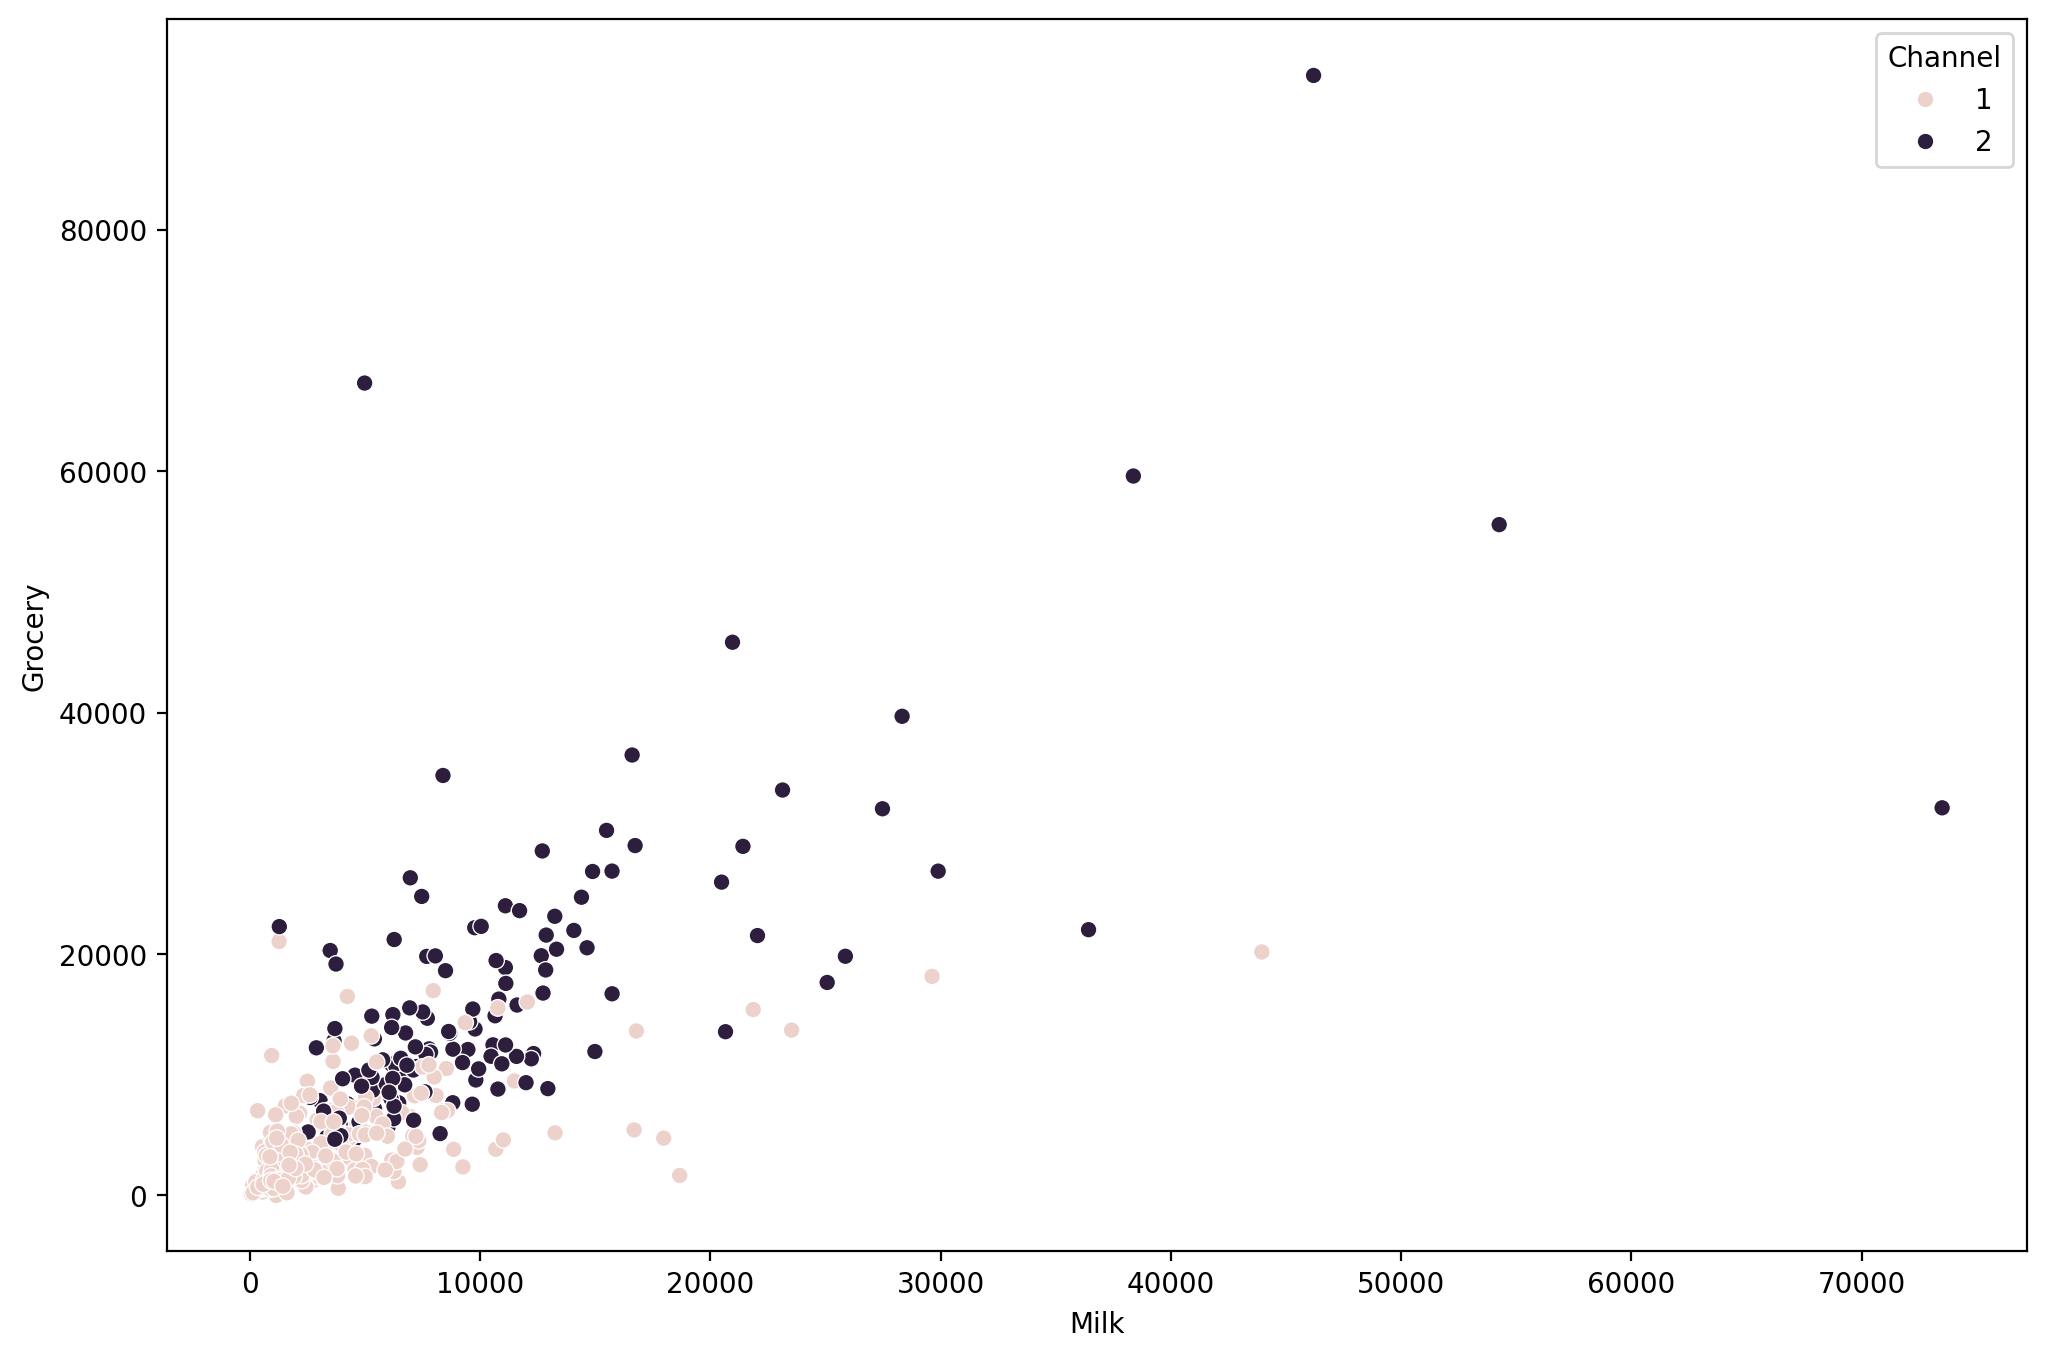

In [10]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=df, x='Milk', y='Grocery', hue='Channel')
plt.show()

**С помощью seaborn построим гистограмму для колонки MILK, выполняя раскраску цветами по колонке Channel. Отобразим разные каналы один "над" другим, вместо их наложения друг на друга, когда один канал находится "за" другим каналом.**

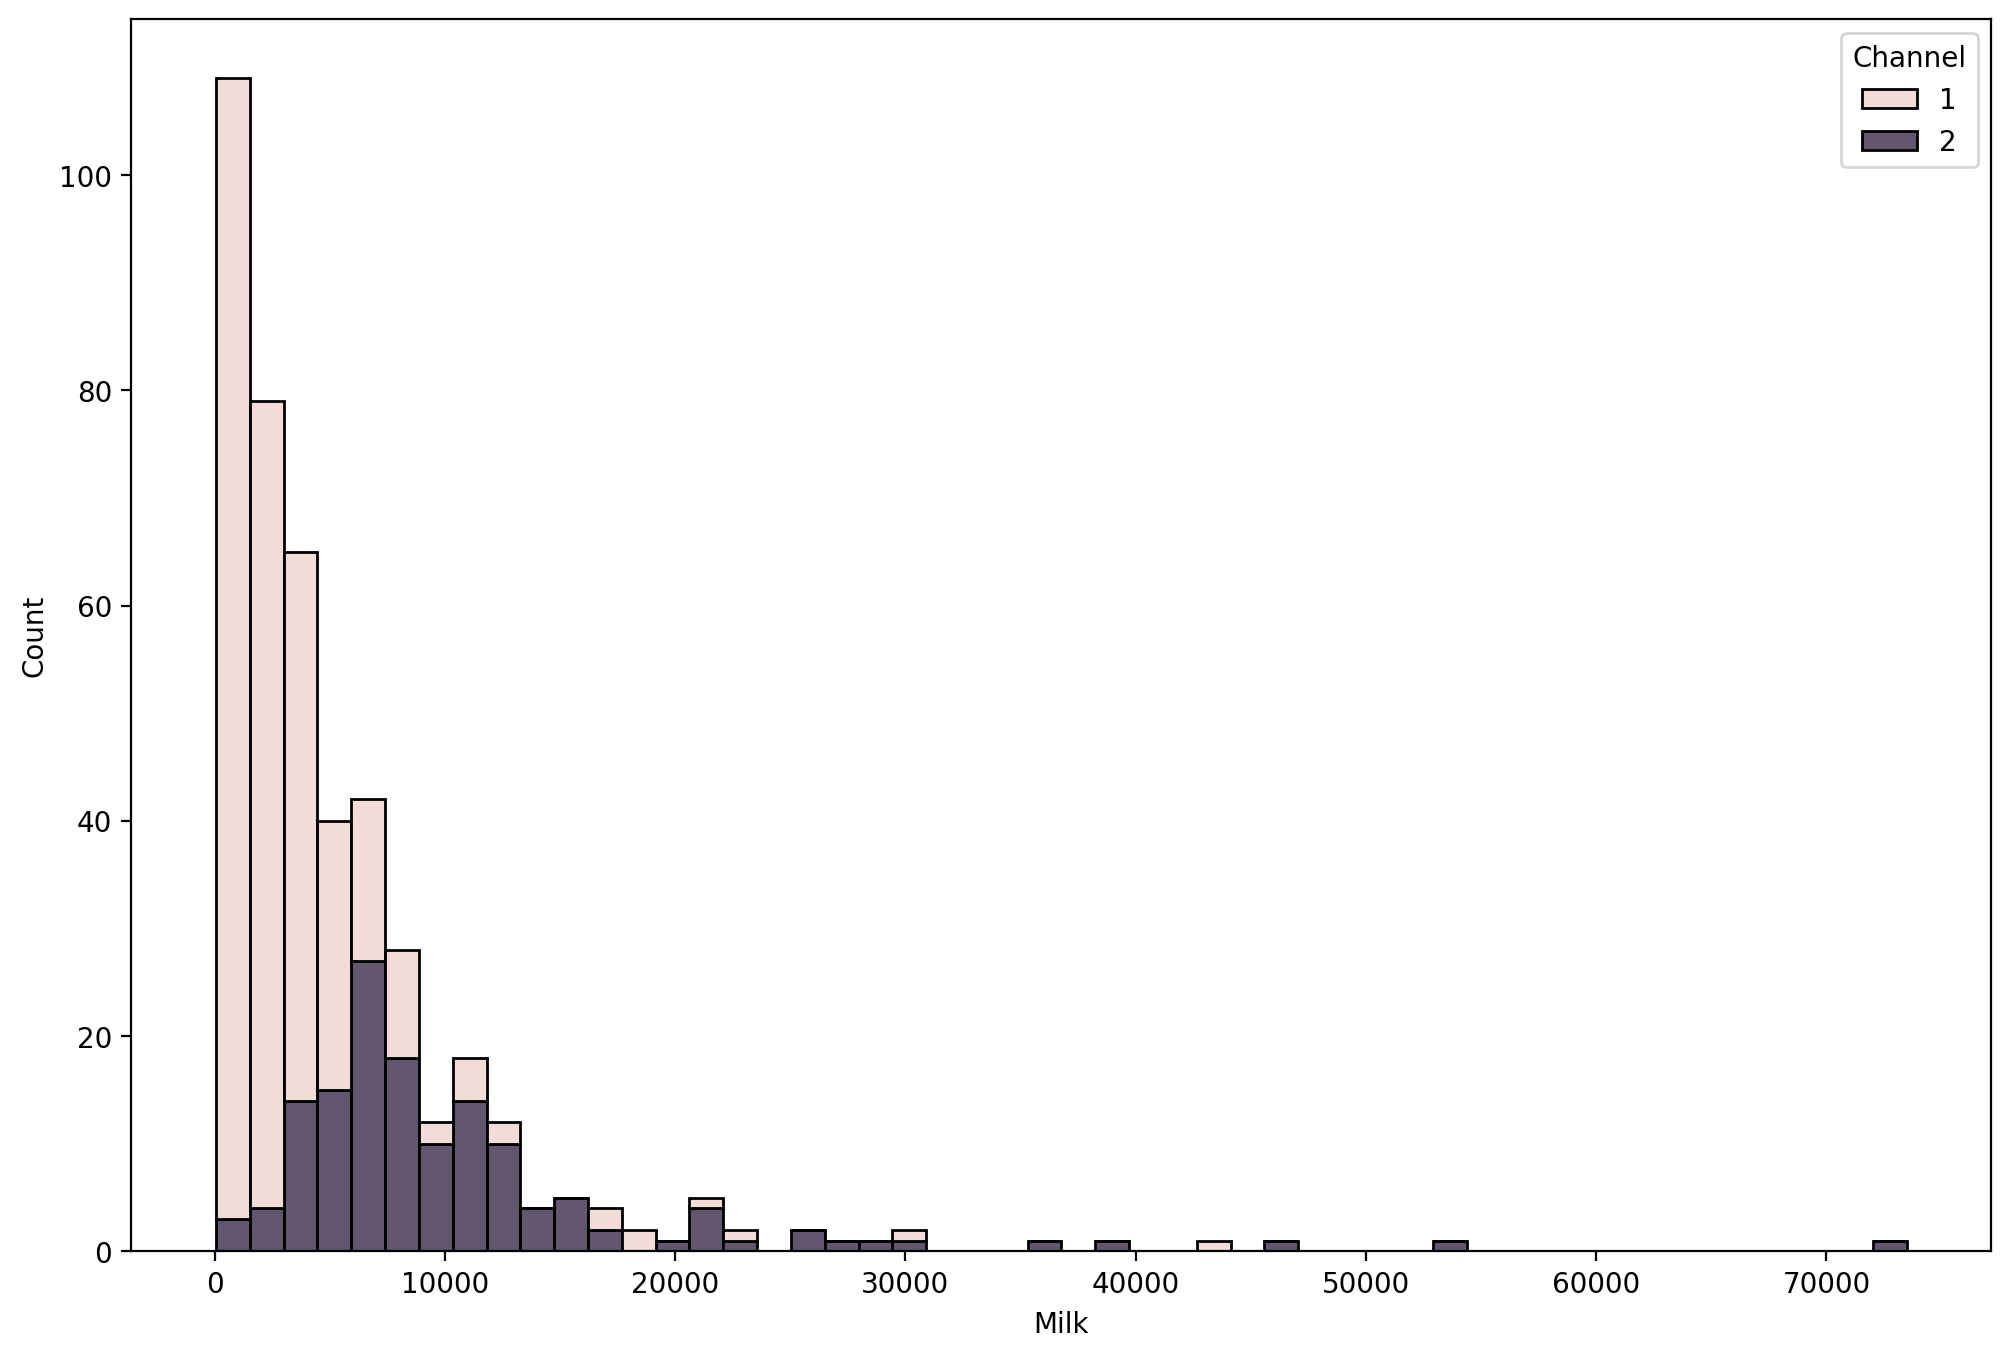

In [12]:
plt.figure(figsize=(12, 8), dpi=200)
sns.histplot(data=df, x='Milk', hue='Channel', multiple='stack')
plt.show()

**Построим график clustermap для корреляций расходов по различным категориям (сами числа тоже нанесём на график).**

<Figure size 2400x1600 with 0 Axes>

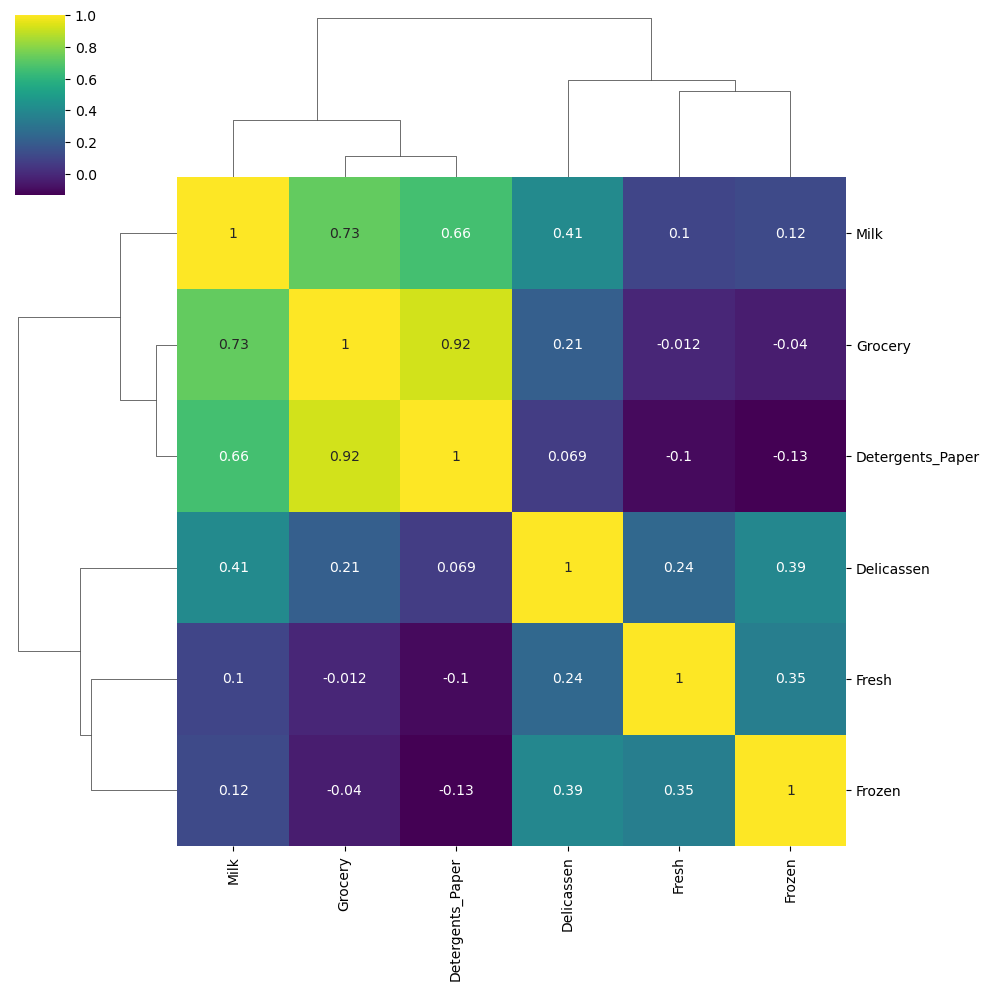

In [14]:
plt.figure(figsize=(12, 8), dpi=200)
sns.clustermap(df.drop(['Channel', 'Region'], axis=1).corr(numeric_only=True), annot=True, cmap='viridis')
plt.show()

**Построим график PairPlot для всех колонок датафрейма, раскрашивая разными цветами по колонке Region.**

<Figure size 1280x960 with 0 Axes>

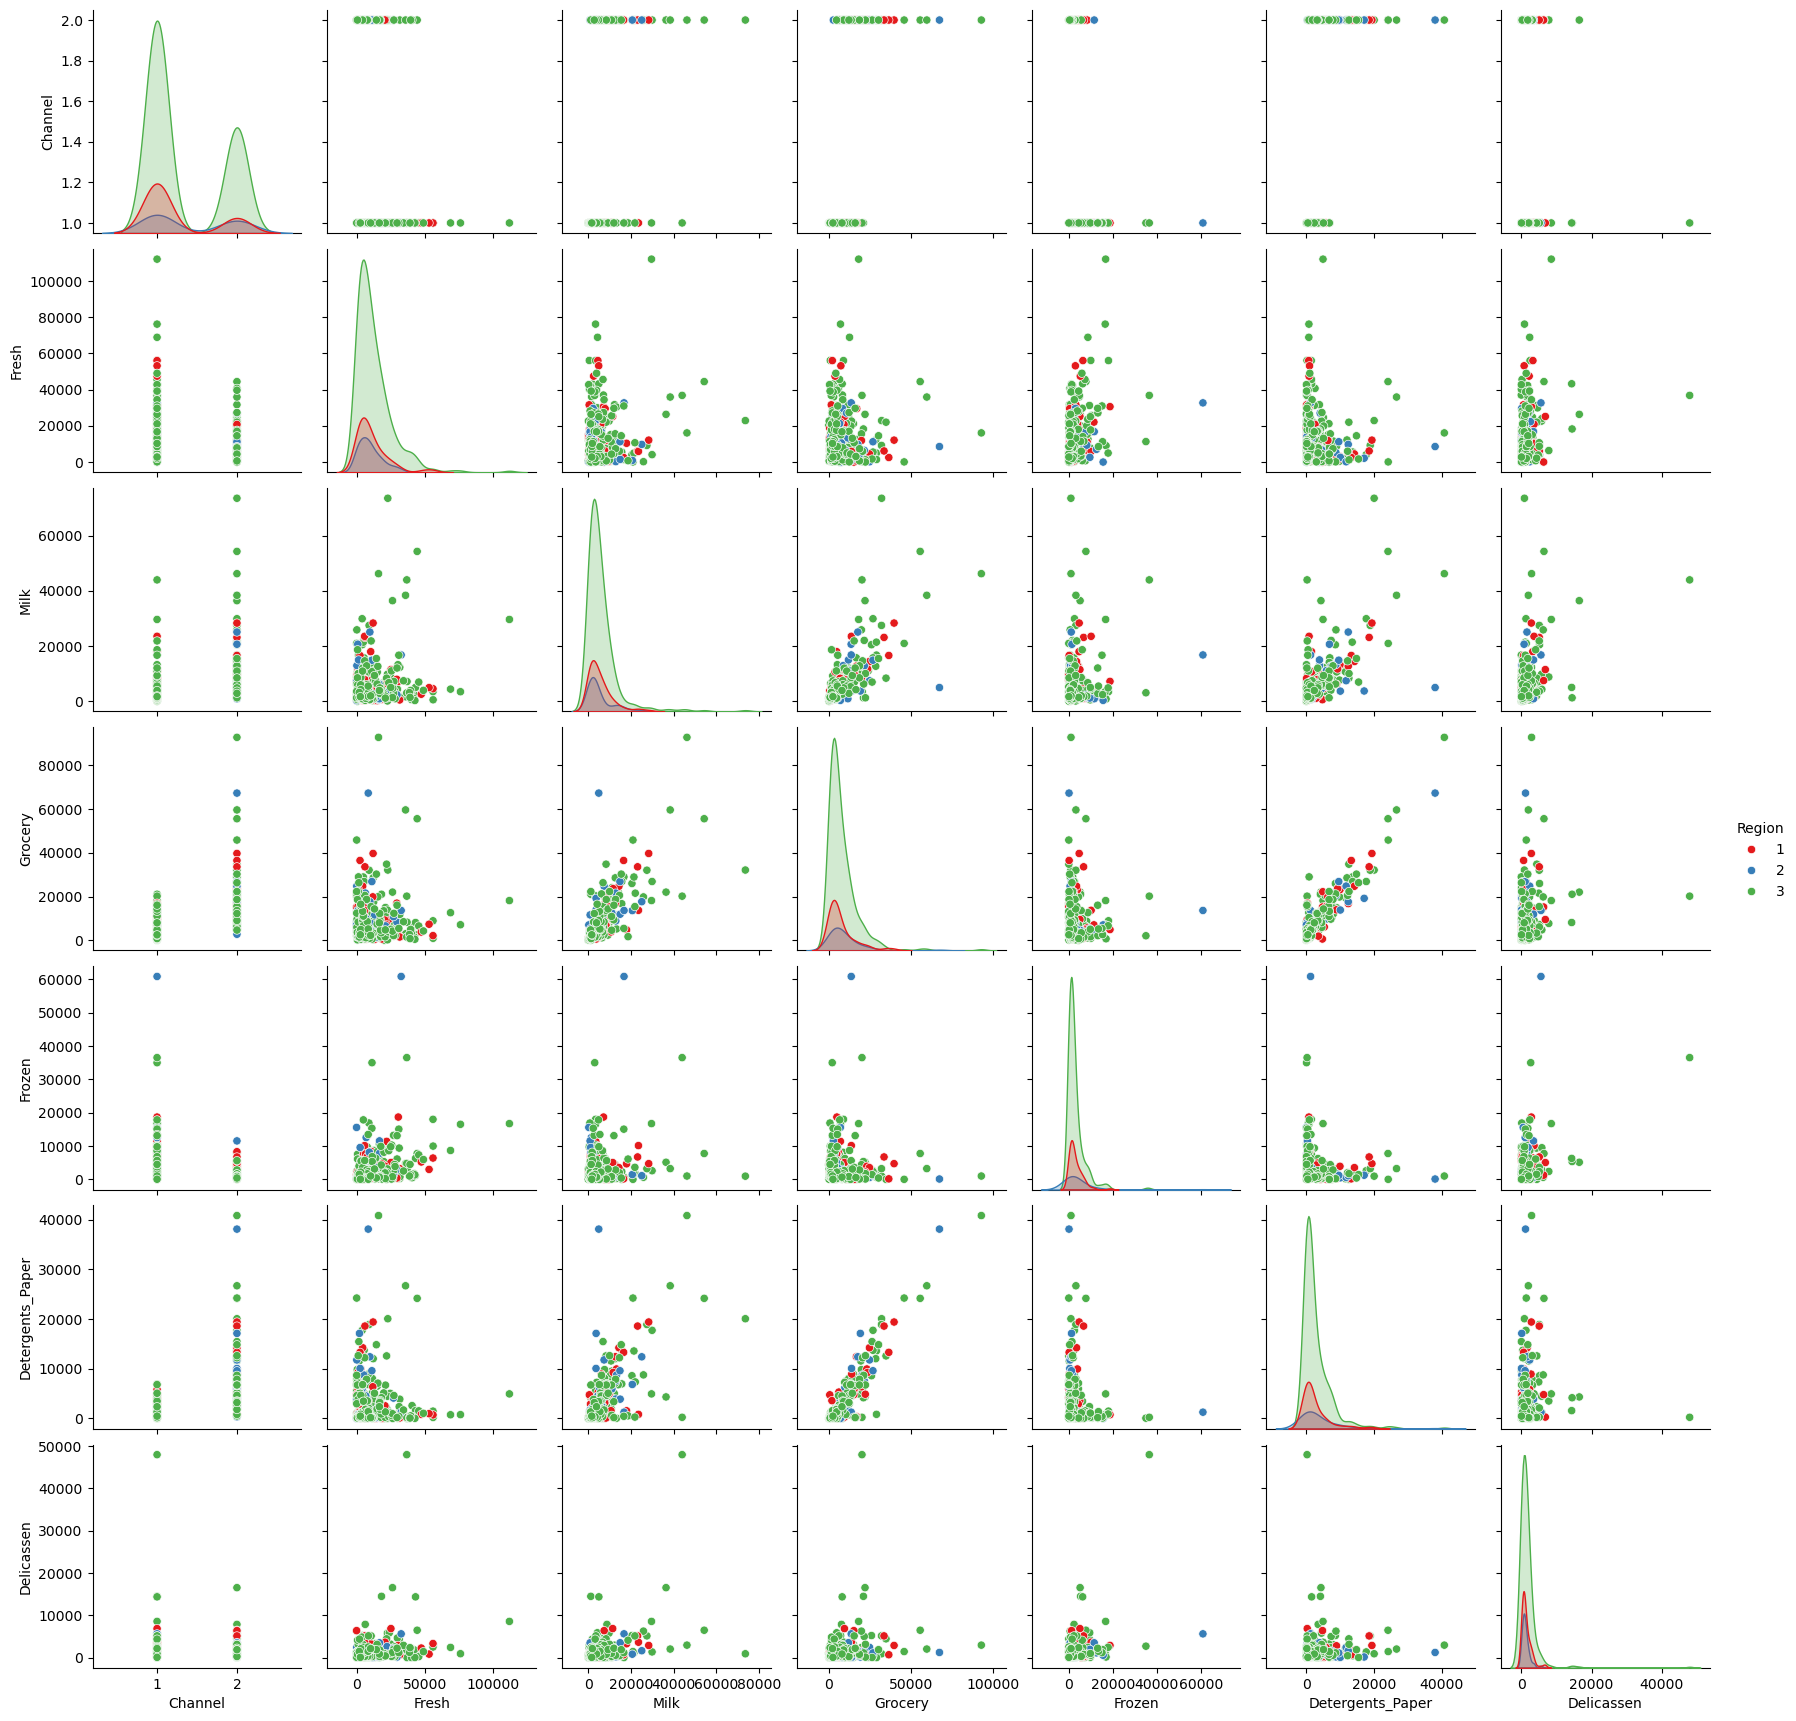

In [16]:
plt.figure(dpi=200)
sns.pairplot(df, hue='Region', palette='Set1');

## DBSCAN

**Поскольку значения разных признаков имеют разные масштабы единиц измерения, выполним масштабирование данных с помощью `StandardScaler`.**

In [18]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()

In [22]:
scaled_X = scaler.fit_transform(df)

In [24]:
scaled_X

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.58936716,
        -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ..., -0.27013618,
         0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.13753572,
         0.13323164,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ..., -0.54337975,
         2.51121768,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.41944059,
        -0.56977032,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.62009417,
        -0.50488752, -0.52286938]])

**C помощью DBSCAN и цикла for создадим набор моделей для различных значений параметра эпсилон. В качестве параметра min_samples возьмём значение 2 умножить на количество признаков. Во время цикла сохраним процент точек-выбросов. Будем использовать следующий диапазон значений эпсилон:**

    np.linspace(0.001,3,50)

In [26]:
from sklearn.cluster import DBSCAN

In [28]:
outlier_percent = []
number_of_outliers = []

for eps in np.linspace(0.001, 3, 50):

    dbscan = DBSCAN(eps=eps, min_samples=2*scaled_X.shape[1])
    dbscan.fit(scaled_X)

    number_of_outliers.append(np.sum(dbscan.labels_ == -1))

    percent_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    outlier_percent.append(percent_outliers)

**Построим график lineplot для процента точек-выбросов в зависимости от значений эпсилон.**

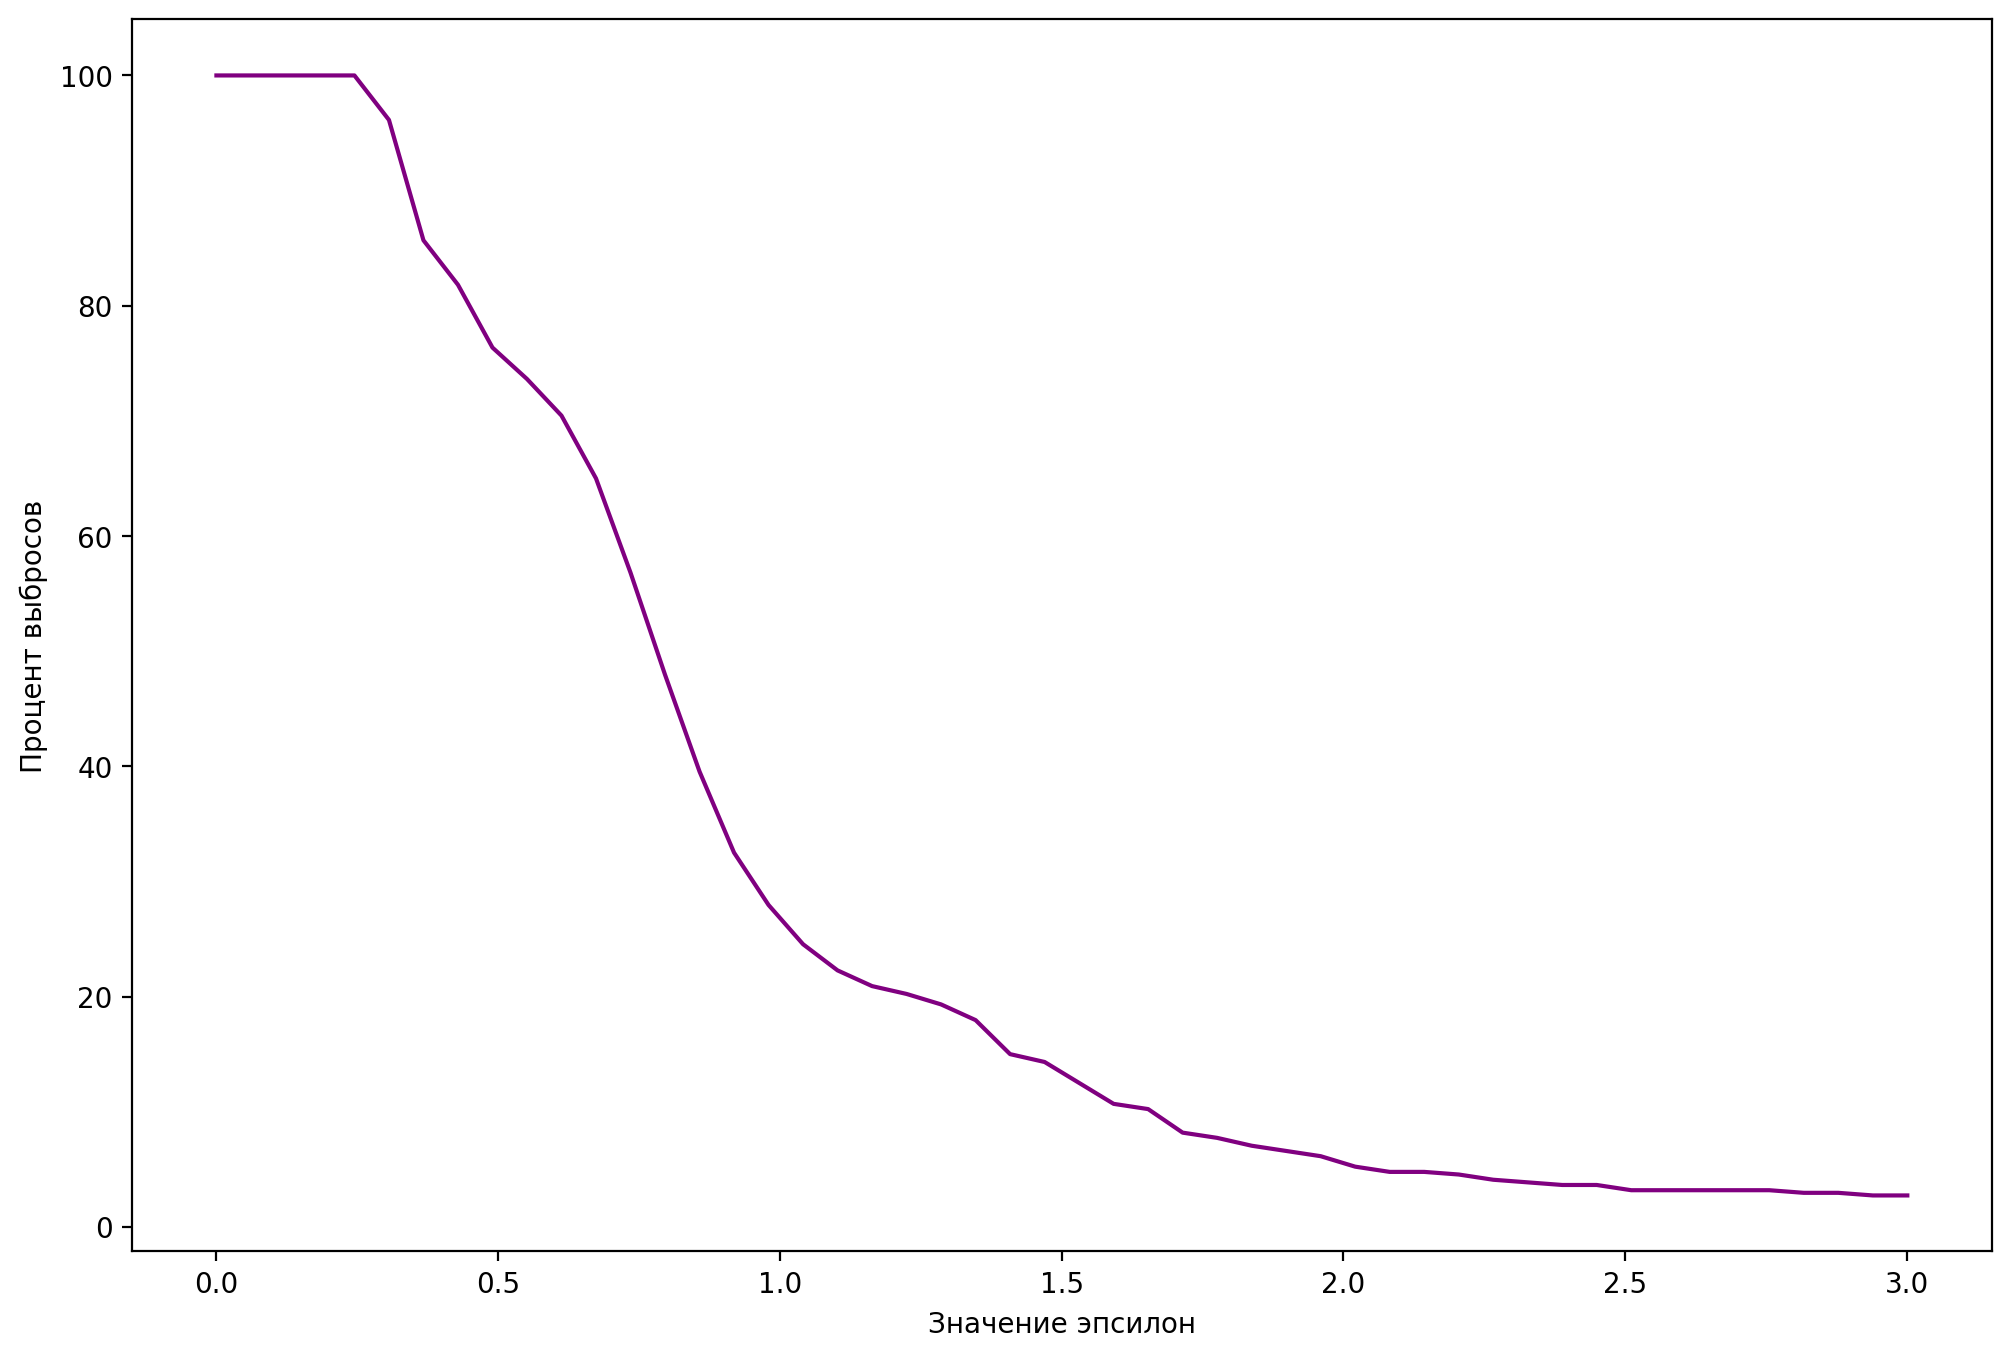

In [30]:
plt.figure(figsize=(12, 8), dpi=200)
sns.lineplot(x=np.linspace(0.001, 3, 50), y=outlier_percent, c='purple')
plt.xlabel('Значение эпсилон')
plt.ylabel('Процент выбросов')
plt.show()

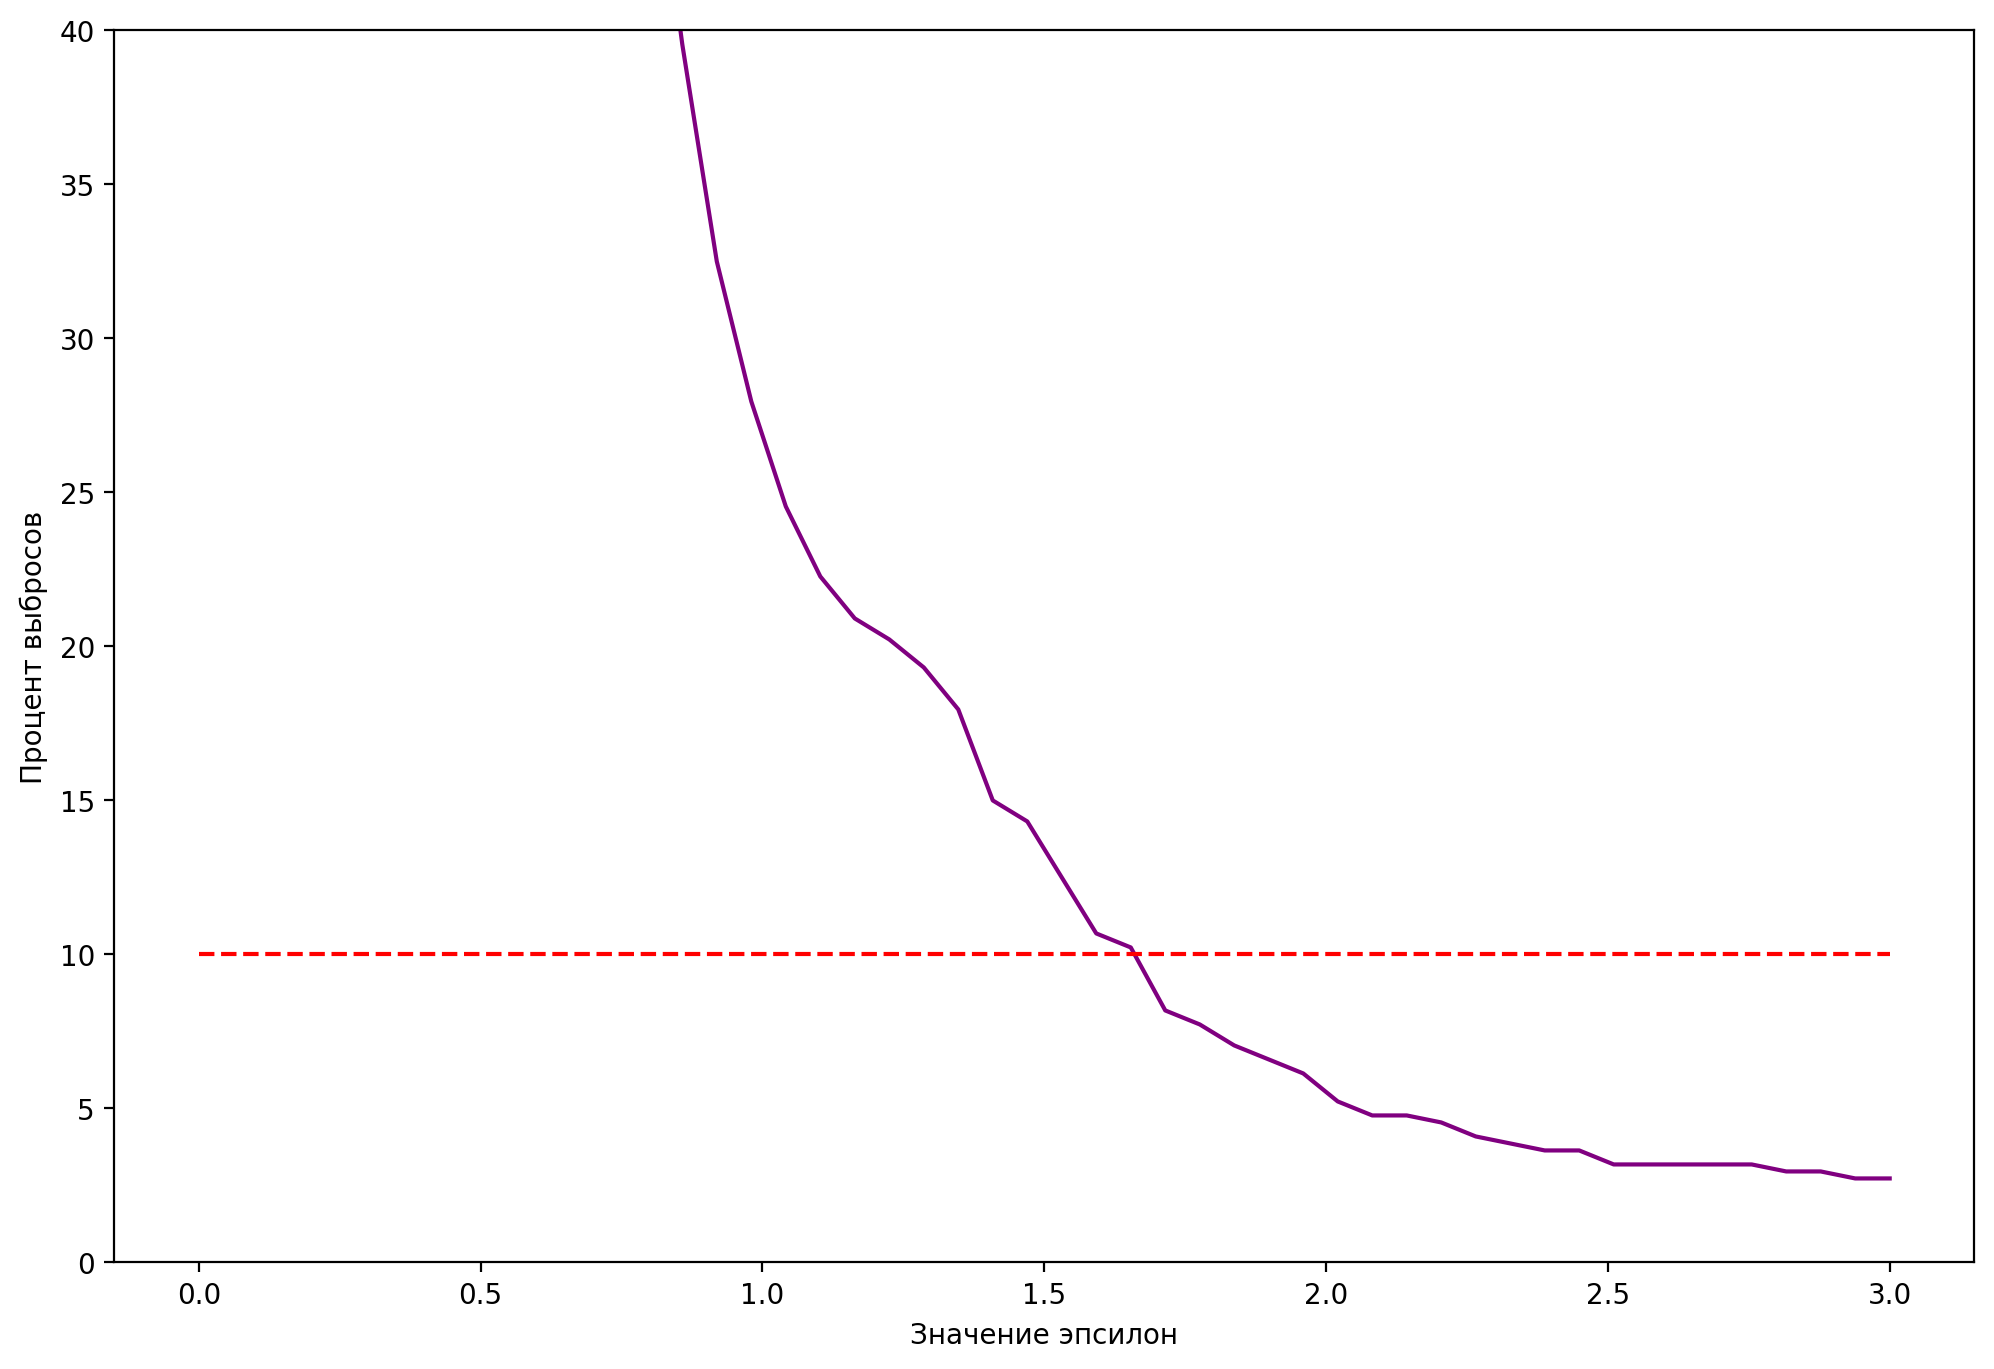

In [32]:
plt.figure(figsize=(12, 8), dpi=200)
sns.lineplot(x=np.linspace(0.001, 3, 50), y=outlier_percent, c='purple')
plt.ylim(0, 40)
plt.hlines(y=10, xmin=0, xmax=3, color='red', ls='--')
plt.xlabel('Значение эпсилон')
plt.ylabel('Процент выбросов')
plt.show()

## DBSCAN для выбранного значения эпсилон

**На основе графике в предыдущем задании, создадим модель DBSCAN с выбранным значением эпсилон `eps=2`.**

In [34]:
dbscan_model = DBSCAN(eps=2, min_samples=2*scaled_X.shape[1])

In [36]:
dbscan_model.fit(scaled_X)

DBSCAN(eps=2, min_samples=16)

**Построим график scatterplot для колонок Milk и Grocery, раскрашивая данные разными цветами по результатам работы модели DBSCAN.**

In [38]:
dbscan_model.labels_

array([ 0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,
        1,  0,  1,  0,  1,  1, -1,  0,  0,  1,  1,  0,  1,  1,  1,  1,  1,
        1,  0,  1,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0, -1,  0,  0,  1,
        1,  0,  0,  1,  1, -1,  0,  1,  1,  0, -1,  0,  0,  1, -1,  1,  0,
        1,  1,  1, -1,  1,  0,  0,  1,  1,  0,  1,  1,  1,  0,  0,  1,  0,
       -1, -1, -1,  1,  1,  1,  1, -1, -1,  0,  1,  0,  1,  1,  1,  0,  0,
        0, -1,  1,  1,  0,  0,  0,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  0,  1, -1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  0,  0,  1,  0,  0,  0,  1,  1,  0,  0,  0,  0,  1,  1,  1,
        0, -1,  1,  0,  1,  0,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,
        1,  0,  0,  1,  1,  1,  0,  1,  1, -1,  0,  1,  1,  0,  0,  1,  1,
        1,  0,  1,  0,  1,  0,  1, -1,  1,  1,  0,  1,  0,  1,  0,  1,  1,
        1,  1,  0,  1,  1

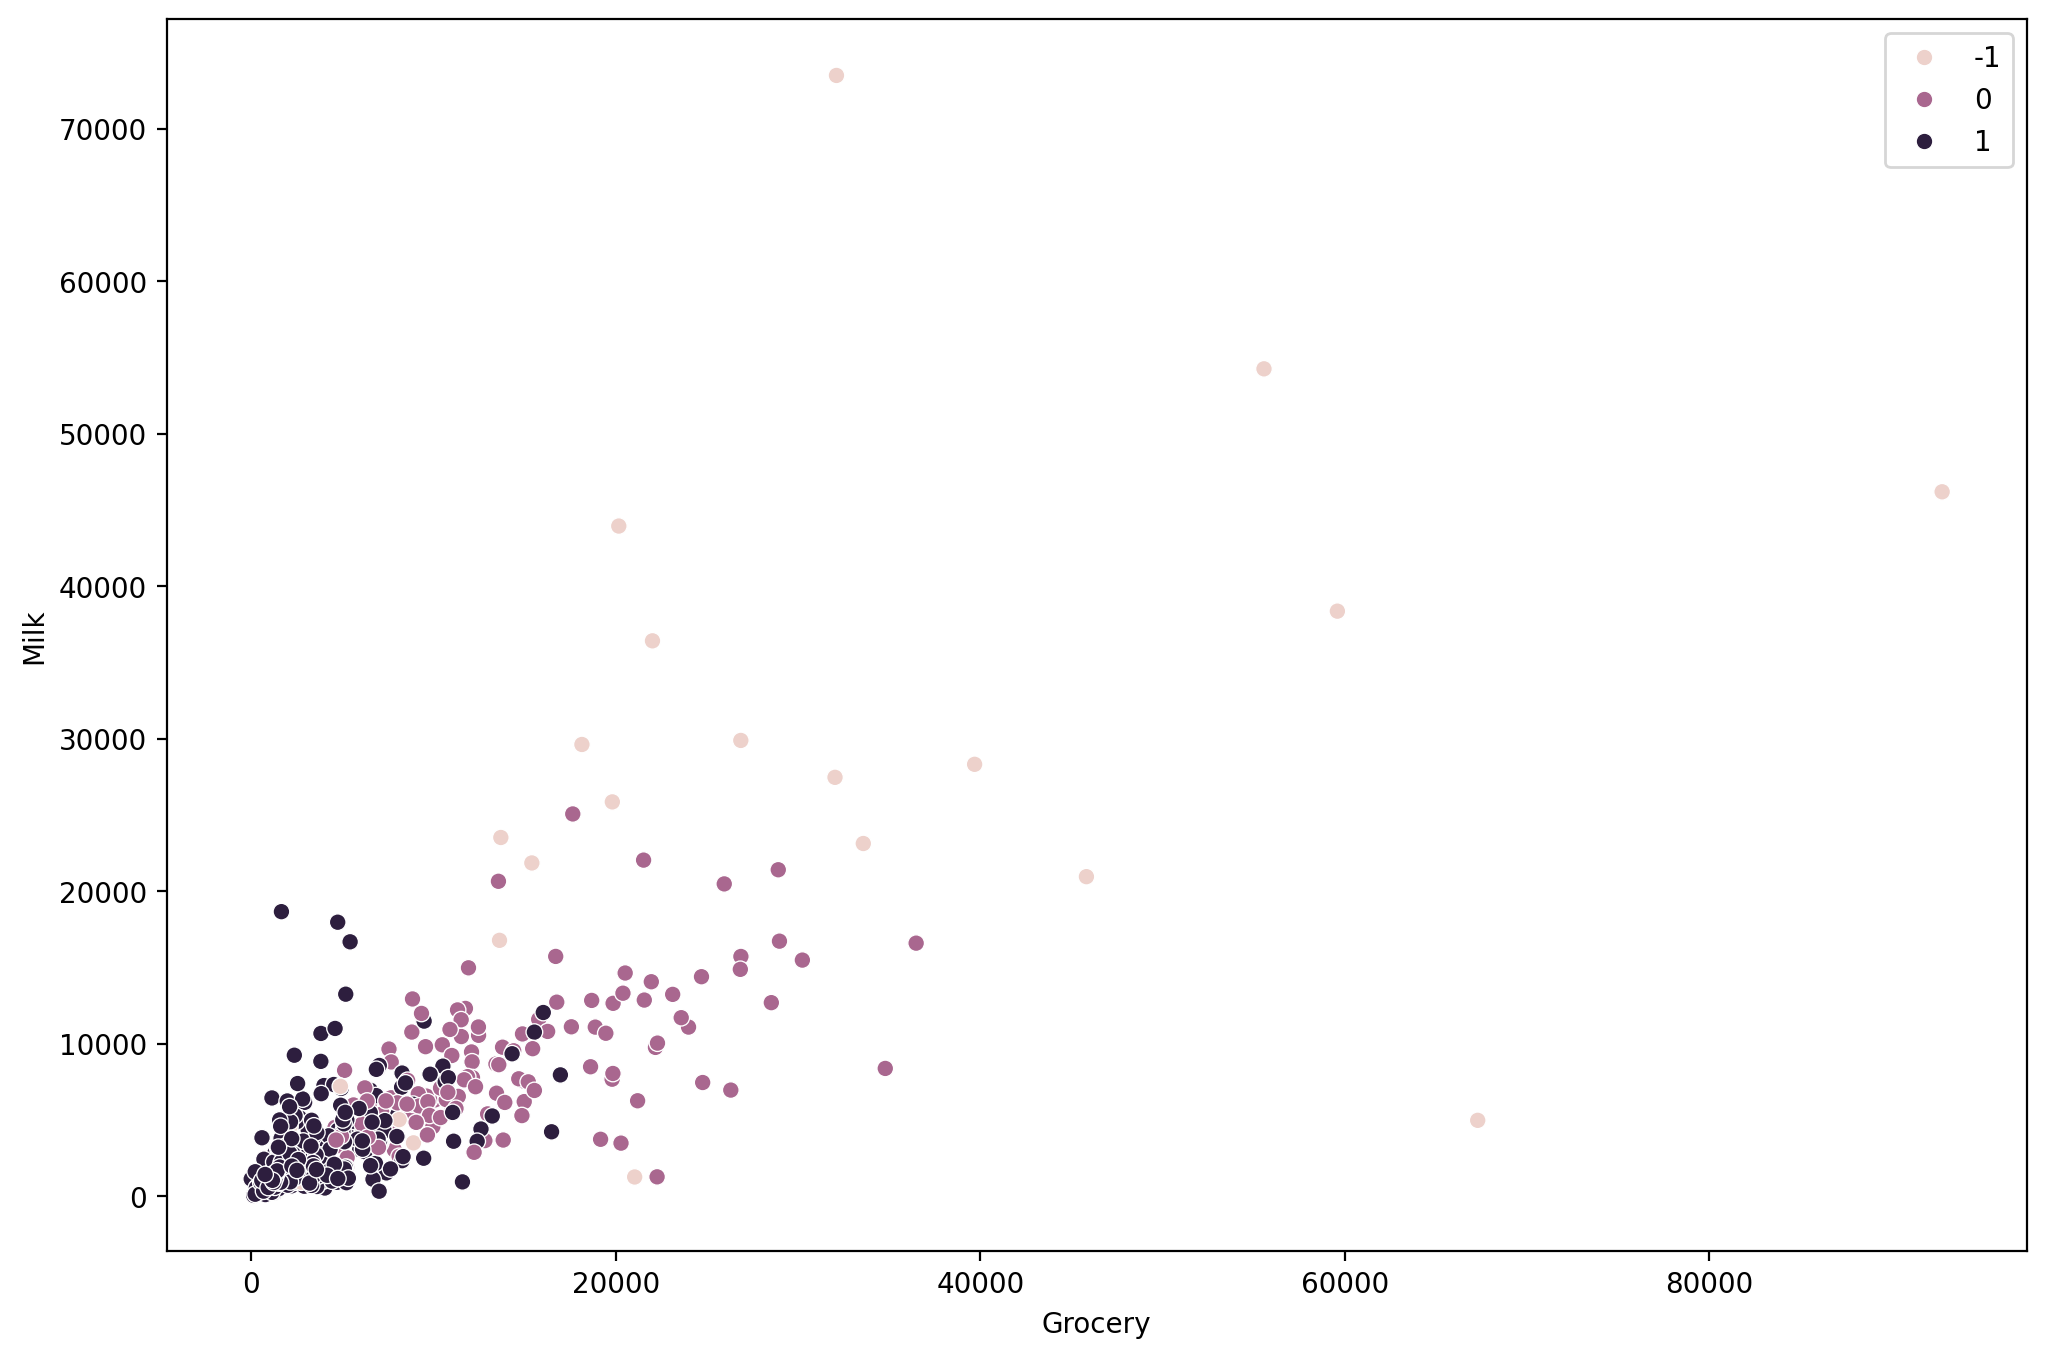

In [40]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=df, x='Grocery', y='Milk', hue=dbscan_model.labels_)
plt.show()

**Построим график scatterplot для колонок Milk и Detergents Paper, раскрашивая данные разными цветами по результатам работы модели DBSCAN.**

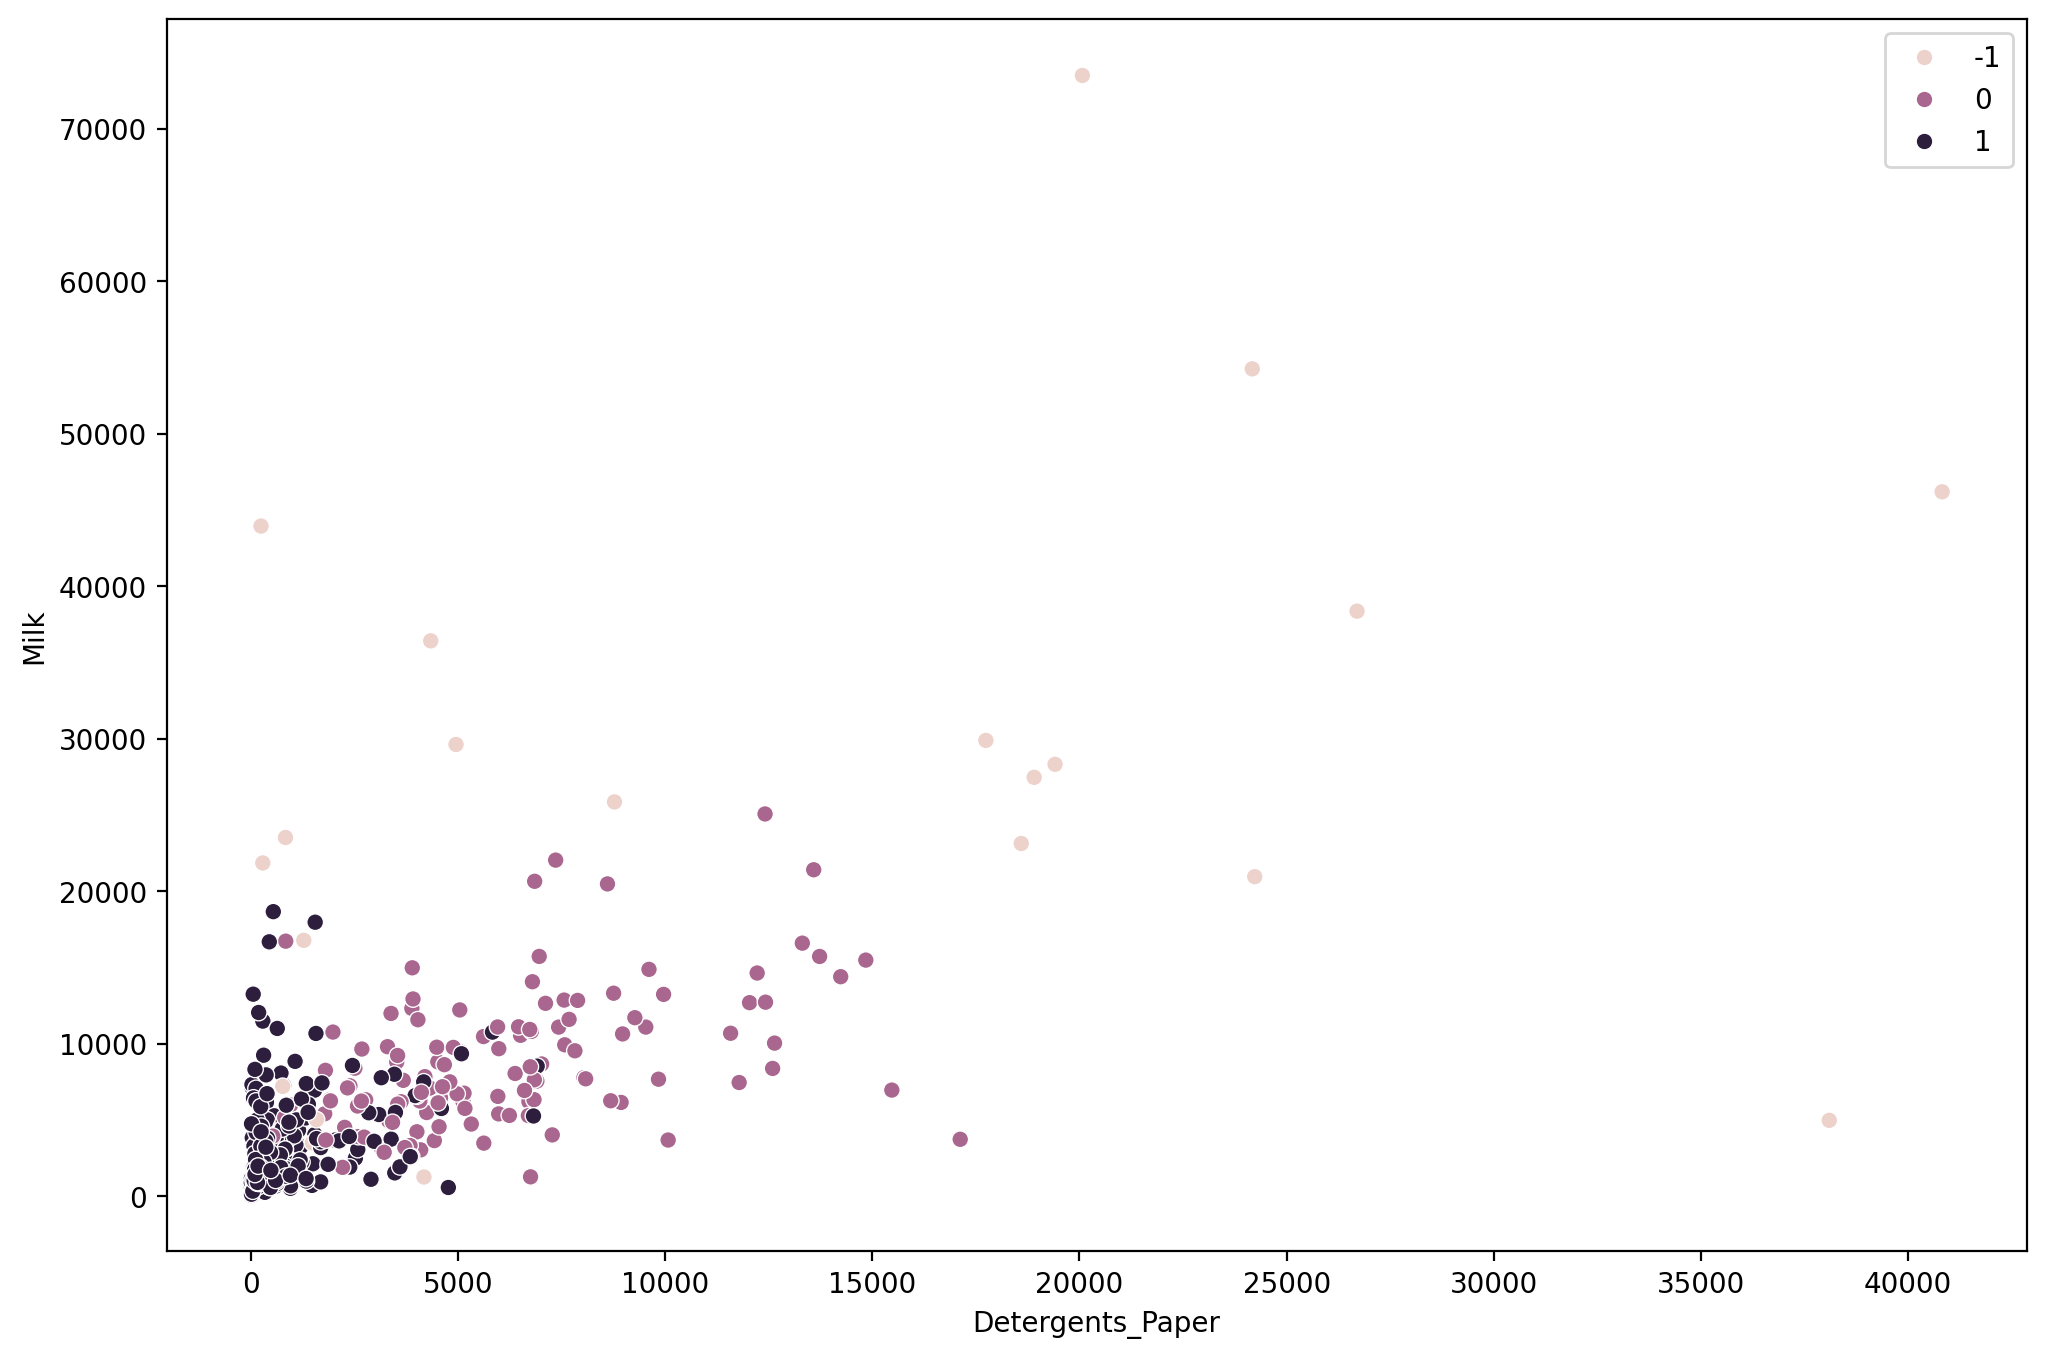

In [42]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=df, x='Detergents_Paper', y='Milk', hue=dbscan_model.labels_)
plt.show()

**Создадим новую колонку в исходном датафрейме, назовём эту колонку "Labels" и запишем в неё результаты работы модели DBSCAN - значения labels.**

In [44]:
df['Labels'] = dbscan_model.labels_

In [46]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,0


**Вычислим средние значения расходов по различным категориям, причём отдельно для каждого из кластеров (включая кластер -1 для выбросов). Сравним расходы разных кластеров между собой (по отдельным категориям расходов).**

In [48]:
df_labels = df.drop(['Channel', 'Region'], axis=1).groupby('Labels').mean()

In [50]:
df_labels

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels,,,,,,
-1,27729.920000,22966.960000,26609.600000,11289.640000,11173.560000,6707.160000
0,8227.666667,8615.852713,13859.674419,1447.759690,5969.581395,1498.457364
1,12326.972028,3023.559441,3655.328671,3086.181818,763.783217,1083.786713


**Выполним нормализацию таблицы с данными, полученной выше, с помощью MinMaxScaler - чтобы значения менялись в диапазоне от 0 до 1. После этого построим тепловую карту heatmap для получившихся значений.**

In [52]:
from sklearn.preprocessing import MinMaxScaler

In [54]:
scaler_two = MinMaxScaler()

In [56]:
data = scaler_two.fit_transform(df_labels)

In [58]:
scaled_df_labels = pd.DataFrame(data, df_labels.index, df_labels.columns)

In [60]:
scaled_df_labels

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels,,,,,,
-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0,0.000000,0.280408,0.444551,0.000000,0.500087,0.073741
1,0.210196,0.000000,0.000000,0.166475,0.000000,0.000000


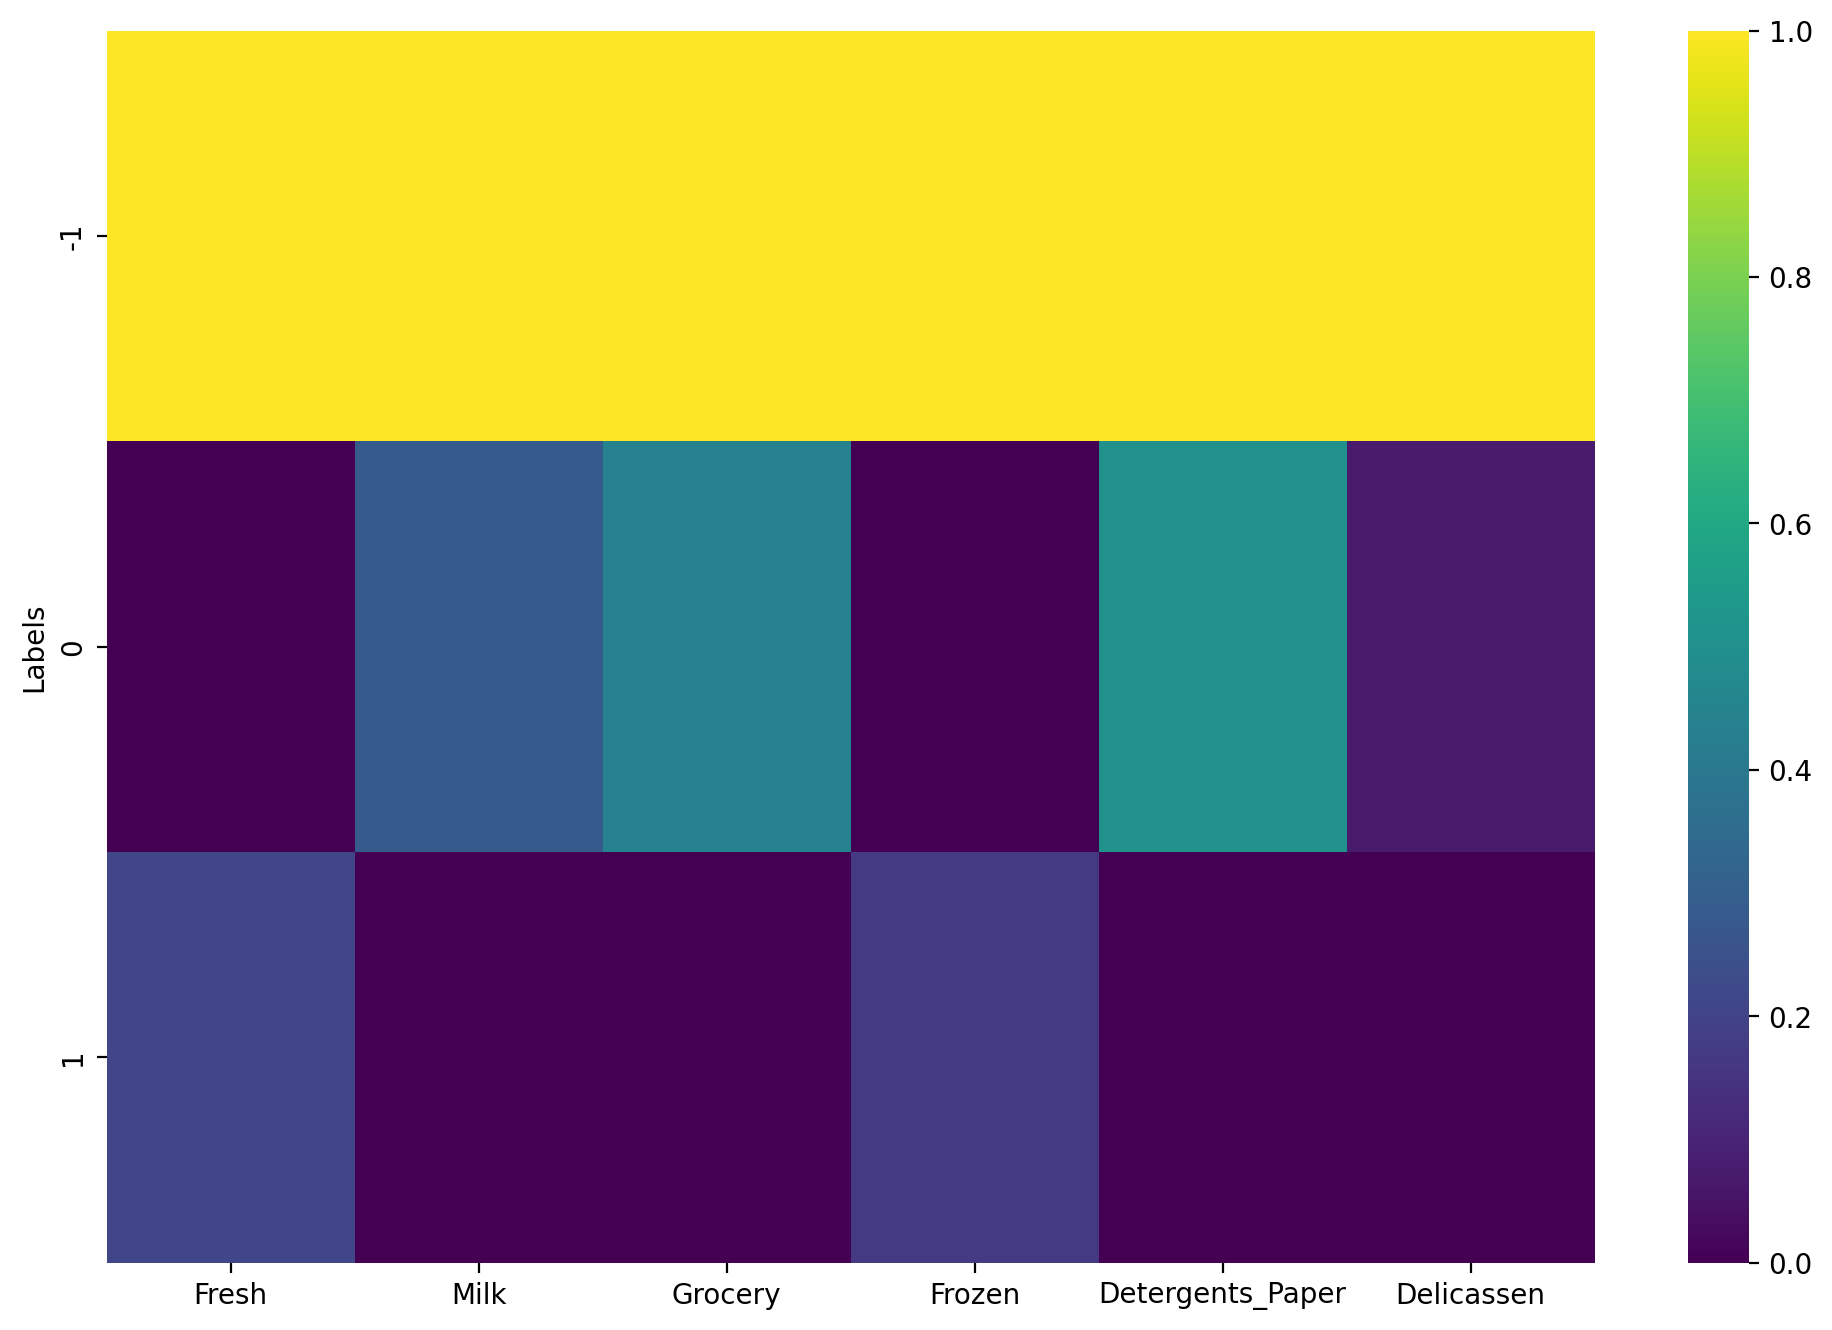

In [62]:
plt.figure(figsize=(12, 8), dpi=200)
sns.heatmap(scaled_df_labels, cmap='viridis')
plt.show()

**Построим ещё одну тепловую карту - такую же, как и в предыдущем задании, но на этот раз предварительно удалим выбросы из рассмотрения.**

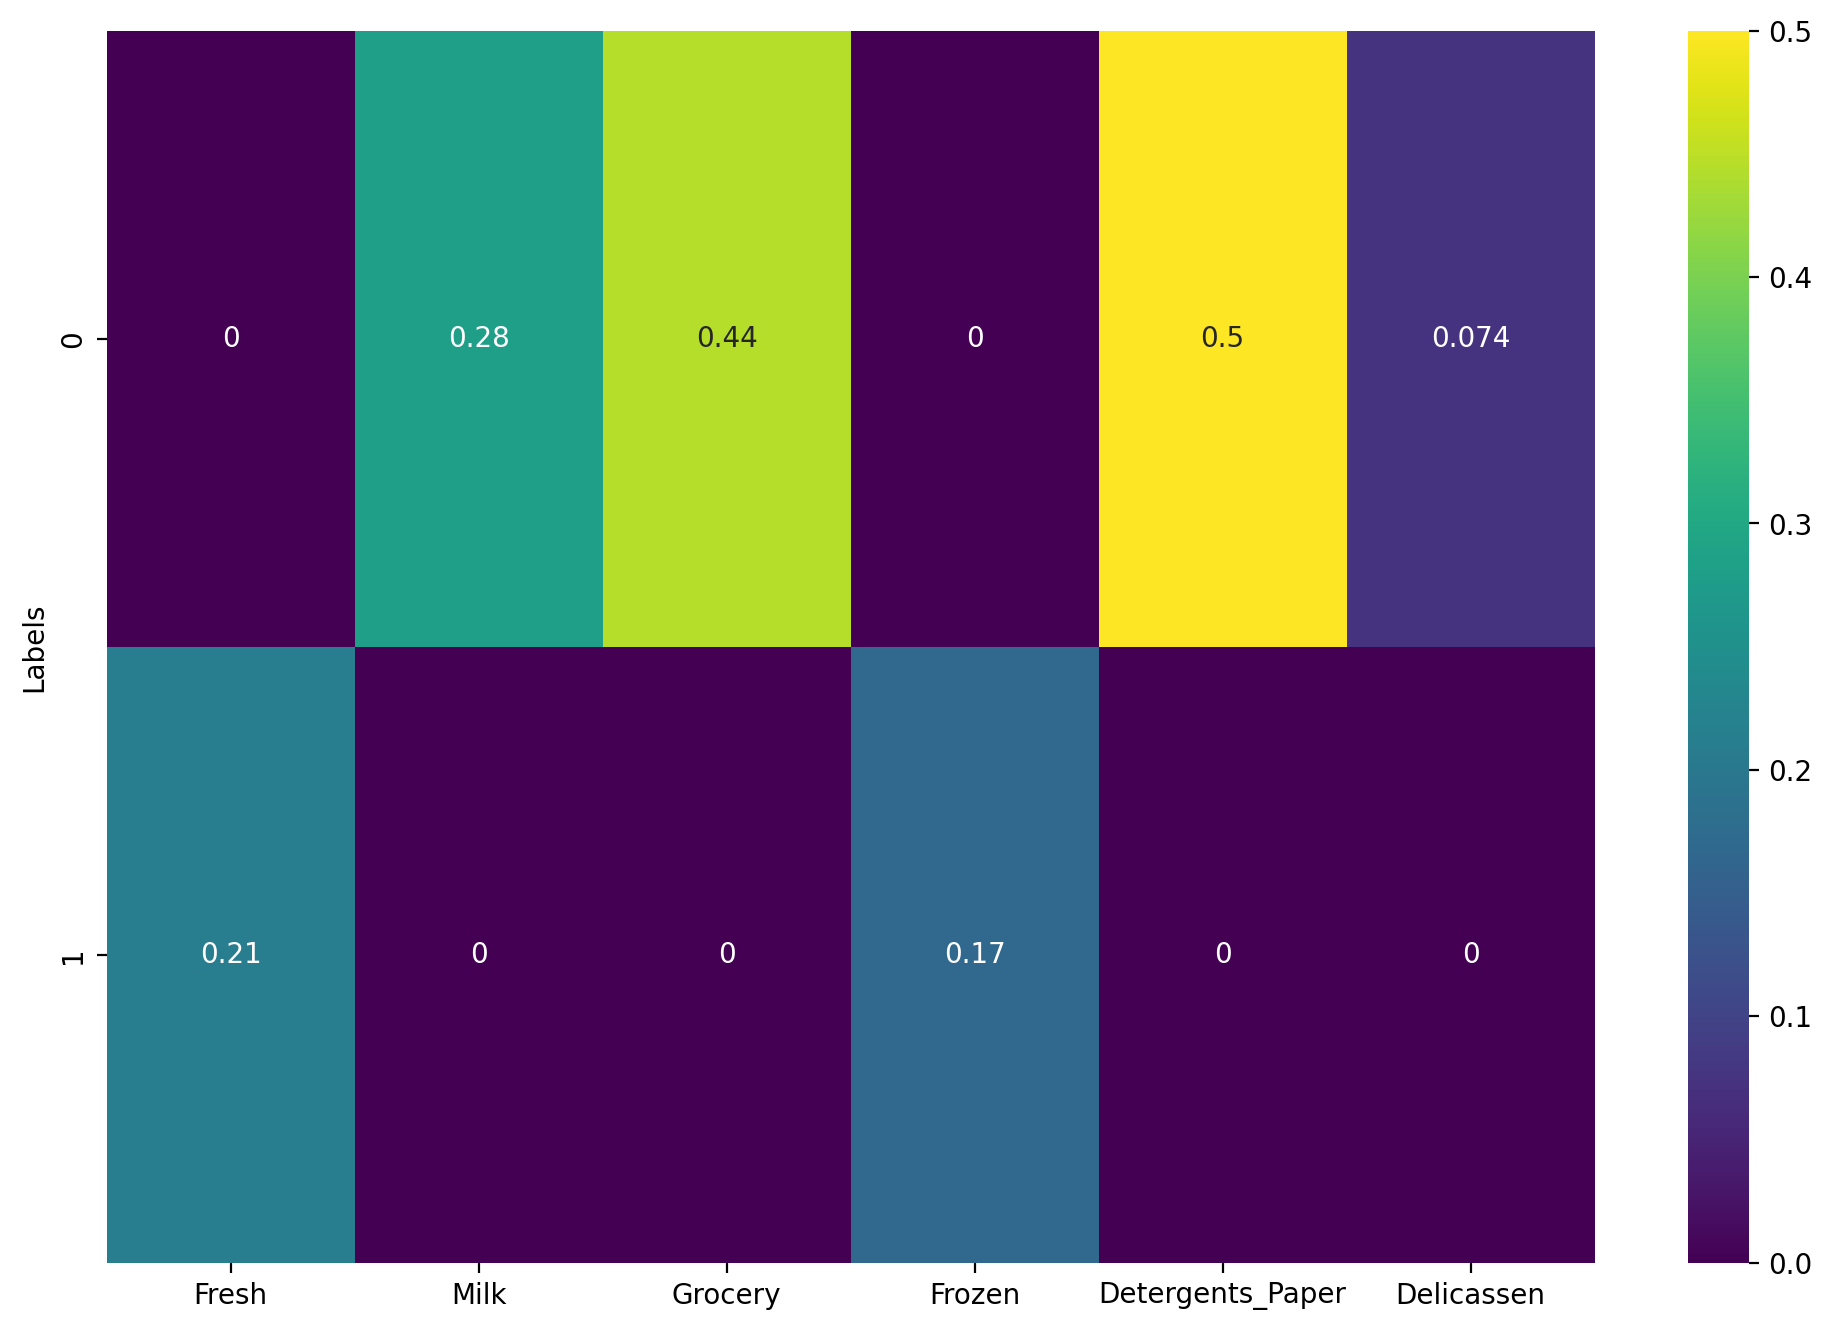

In [64]:
plt.figure(figsize=(12, 8), dpi=200)
sns.heatmap(scaled_df_labels.drop(-1, axis=0), cmap='viridis', annot=True)
plt.show()

**Эти два кластера сильно различаются по категориям Milk, Grocery и Detergents_Paper.**